In [1]:
# general
import sys, os, path
import datetime

# nn related
import torch as th
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
import seaborn as sns
import tikzplotlib as tikz

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess as pre
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import * # get_invariants, get_tensor_functions, sigmoid_scaling, mean_std_scaling
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *

# standard datatype
dtype = th.double

In [3]:
with NoStdStreams():
    # read in rans solution from b_ml and komega
    path = '/home/leonriccius/Desktop/PeriodicHills/Re5600/Re5600_kOmega_150_dd_add_features_low_lr/'
    rans_time = max([int(entry) for entry in os.listdir(path) if entry.isnumeric()])
    grid_rans = pre.readCellCenters(rans_time, path)
    u_rans = pre.readVectorData(rans_time, 'U', path)
    k_rans = pre.readScalarData(rans_time, 'k', path)
    u_levm = pre.readVectorData('30000', 'U', path)
    k_levm = pre.readScalarData('30000', 'k', path)

    # read in k epsilon model
    path_rans_bdns = '/home/leonriccius/Desktop/PeriodicHills/Re5600/Re5600_kepsilon_150/'
    rans_time = max([int(entry) for entry in os.listdir(path_rans_bdns) if entry.isnumeric()])
    u_kepsilon = pre.readVectorData(rans_time, 'U', path_rans_bdns)
    k_kepsilon = pre.readScalarData(rans_time, 'k', path)

    # read in rans solution from b_dns
    path_rans_bdns = '/home/leonriccius/Desktop/PeriodicHills/Re5600/Re5600_kOmega_150_dns/'
    rans_time = max([int(entry) for entry in os.listdir(path_rans_bdns) if entry.isnumeric()])
    u_rans_dns = pre.readVectorData(rans_time, 'U', path_rans_bdns)
    k_rans_dns = pre.readScalarData(rans_time, 'k', path)

    # read in dns solution
    path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata/PeriodicHills/5600'
    grid_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))
    u_dns = th.load(os.sep.join([path_dns, 'u_dns-torch.th']))
    k_dns = th.load(os.sep.join([path_dns, 'k_dns-torch.th']))

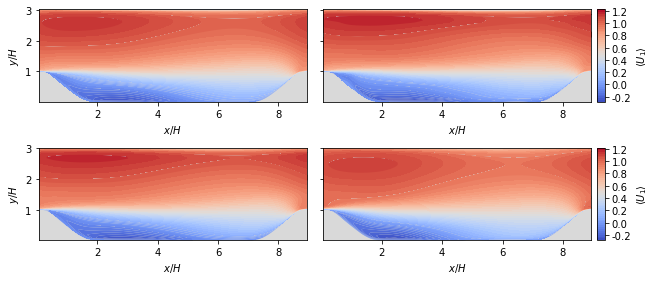

In [12]:
# set refinement level and extent of grid
ref = 15
gamma = 0.995

# find min an max of x coordinate
x_min, x_max = np.min(grid_rans[:,0].numpy()), np.max(grid_rans[:,0].numpy())
x_mean = 0.5*(x_max - x_min)
x_min = x_mean - gamma*(x_mean - x_min)
x_max = x_mean - gamma*(x_mean - x_max)

# find min an max of y coordinate
y_min, y_max = np.min(grid_rans[:,1].numpy()), np.max(grid_rans[:,1].numpy())
y_mean = 0.5*(y_max - y_min)
y_min = y_mean - gamma*(y_mean - y_min)
y_max = y_mean - gamma*(y_mean - y_max)

# compute number of points per coordinate
np_x = int(ref*(x_max - x_min))
np_y = int(ref*(y_max - y_min))

# get grid
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, np_x), np.linspace(y_min, y_max, np_y))
grid_y = ph_interp(grid_x)*(y_max - grid_y)/y_max + grid_y

# interpolate u
grid_u_rans = griddata(grid_rans[:,0:2], u_rans.detach().numpy(), (grid_x, grid_y), method = 'linear')
grid_u_levm = griddata(grid_rans[:,0:2], u_levm.detach().numpy(), (grid_x, grid_y), method = 'linear')
grid_u_kepsilon = griddata(grid_rans[:,0:2], u_kepsilon.detach().numpy(), (grid_x, grid_y), method = 'linear')
grid_u_rans_dns = griddata(grid_dns[:,0:2], u_rans_dns.detach().numpy(), (grid_x, grid_y), method = 'linear')
grid_u_dns = griddata(grid_dns[:,0:2], u_dns.detach().numpy(), (grid_x, grid_y), method = 'linear') #, fill_value=0.)

# get min an max of (b_pred, b_test) for colormap
idx = [0]
tmp = th.cat((u_rans[:,idx[0]], u_dns[:,idx[0]])).detach().numpy()
u_min = np.min(tmp)
u_max = np.max(tmp)
levels = np.linspace(u_min, 1.22, 50)

# plot layout
nrows = 2
ncols = 2
s = 1.0

# create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*4.5*ncols, s*1.9*nrows), sharex=False, sharey=True,
                       constrained_layout=True)

# set colormap
cmap = matplotlib.cm.get_cmap("coolwarm")

# make contour plots
levm_plot = ax[0,0].contourf(grid_x, grid_y, grid_u_levm[:,:,idx[0]], levels = levels, cmap=cmap)
rans_plot = ax[0,1].contourf(grid_x, grid_y, grid_u_rans[:,:,idx[0]], levels = levels, cmap=cmap)
rans_dns_plot = ax[1,0].contourf(grid_x, grid_y, grid_u_rans_dns[:,:,idx[0]], levels = levels, cmap=cmap)
dns_plot = ax[1,1].contourf(grid_x, grid_y, grid_u_dns[:,:,idx[0]], levels = levels, cmap=cmap)

# remove contour lines
for contour in [levm_plot, rans_plot, rans_dns_plot, dns_plot]:
    for c in contour.collections:
        c.set_edgecolor("face")
        c.set_linewidth(0.00000000000000001)

# set colorbars
for j in range(2):
    cbar = fig.colorbar(rans_plot, ax=ax[j,:].flat, aspect=15*ncols, format='%.1f', pad=0.0, ticks=np.arange(-0.2,1.4,0.2))
    cbar.set_label(r'$\langle U_1 \rangle$')

# set background color (grey)
for axis in ax.flat:
    axis.set_facecolor([0.85, 0.85, 0.85])
    
# set x labels
ax[1,0].set_xlabel(r'$x/H$', fontsize='medium')
ax[1,1].set_xlabel(r'$x/H$', fontsize='medium')
ax[0,0].set_xlabel(r'$x/H$', fontsize='medium')
ax[0,1].set_xlabel(r'$x/H$', fontsize='medium')

# set shared y labels
ax[0,0].set_ylabel(r'$y/H$', fontsize='medium')
ax[1,0].set_ylabel(r'$y/H$', fontsize='medium')

# set titles
# x_off = -1.2
# y_off = 1.7
# ax[0].text(x_off,y_off, r'LEVM', fontsize='medium', ha='left')
# ax[1].text(x_off,y_off, r'RANS' '\n' r'$b_{ml}$', fontsize='medium', ha='left', va='center')
# ax[2].text(x_off,y_off, r'RANS' '\n' r'$b_{dns}$', fontsize='medium', ha='left', va='center')
# ax[3].text(x_off,y_off, r'DNS', fontsize='medium', ha='left')


# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/numerical_results/propagation/periodic_hills'
fig_name =  'Ux_contour.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

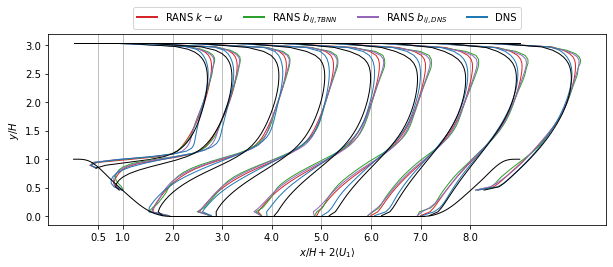

In [11]:
# set path to save figures
# fig_path = '/home/leonriccius/Desktop'

# select x locations to plot
x_data = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
tol = 4e-2
scale_x = 2.0
scale_fig = 1.2

# # # seaborn colors scheme 1
colors = [sns.color_palette()[3],
          sns.color_palette()[2],
          sns.color_palette()[4],
          sns.color_palette()[0]]

# linewidth
linewidth = 1.0

# select components
components = [0]

# set number of columns to plot
ncols = 1
nrows = len(components)

# create figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(scale_fig*7*ncols, scale_fig*3.0*nrows),
                        sharex=True, sharey=True, constrained_layout=True)

plt.xticks(x_data)

for i, cmp in enumerate(components):
    for j, val in enumerate(x_data):
        # find x location in grid
        x_loc = np.argmin(np.absolute(grid_x[0] - val))
        x_val = grid_x[0, x_loc]

        # create mask and select points in the slice
        grid_slice = grid_y[:, x_loc]
        u_dns_slice = grid_u_dns[:, x_loc, cmp]
        u_levm_slice = grid_u_levm[:, x_loc, cmp]
        u_kepsilon_slice = grid_u_kepsilon[:, x_loc, cmp]
        u_rans_slice = grid_u_rans[:, x_loc, cmp]
        u_rans_dns_slice = grid_u_rans_dns[:, x_loc, cmp]

        # plot all bs for current slice
        axs.plot(scale_x*u_levm_slice + val, grid_slice,
                   color=colors[0], linewidth=linewidth)
        axs.plot(scale_x*u_rans_slice + val, grid_slice,
                   color=colors[1], linewidth=linewidth)
        axs.plot(scale_x*u_rans_dns_slice + val, grid_slice,
                   color=colors[2], linewidth=linewidth)
        axs.plot(scale_x*u_dns_slice + val, grid_slice,
                   color=colors[3], linewidth=linewidth)
        axs.plot(scale_x*u_kepsilon_slice + val, grid_slice,
                   color='black', linewidth=linewidth)
        axs.set_ylabel(r'$y/H$')
    
    # plot lower and upper wall of hill and grid
    barymap.plot_periodic_hills_boundaries(axs)
    axs.grid(axis='x')

# plot legend    
leg = axs.legend([r'RANS $k-\omega$', r'RANS $b_{ij,TBNN}$', r'RANS $b_{ij,DNS}$', r'DNS'], bbox_to_anchor=(0.5, 1.00),
                 loc='lower center', ncol=4)

# thicker lines for legend
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

# plot xlabel
axs.set_xlabel(r'$x/H + 2\langle U_1 \rangle$')

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/numerical_results/propagation/periodic_hills'
fig_name =  'Ux_section.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

In [10]:
print('kepsilon   U_i: {:2f},   U_1:{:2f},   U_2:{:2f}'.format(th.sqrt(th.nn.MSELoss()(u_dns[:,0:2], u_kepsilon[:,0:2])),
                                                               th.sqrt(th.nn.MSELoss()(u_dns[:,0], u_kepsilon[:,0])),
                                                               th.sqrt(th.nn.MSELoss()(u_dns[:,1], u_kepsilon[:,1]))))
print('komega     U_i: {:2f},   U_1:{:2f},   U_2:{:2f}'.format(th.sqrt(th.nn.MSELoss()(u_dns[:,0:2], u_levm[:,0:2])),
                                                               th.sqrt(th.nn.MSELoss()(u_dns[:,0], u_levm[:,0])),
                                                               th.sqrt(th.nn.MSELoss()(u_dns[:,1], u_levm[:,1]))))
print('TBNN       U_i: {:2f},   U_1:{:2f},   U_2:{:2f}'.format(th.sqrt(th.nn.MSELoss()(u_dns[:,0:2], u_rans[:,0:2])),
                                                               th.sqrt(th.nn.MSELoss()(u_dns[:,0], u_rans[:,0])),
                                                               th.sqrt(th.nn.MSELoss()(u_dns[:,1], u_rans[:,1]))))
print('bDNS       U_i: {:2f},   U_1:{:2f},   U_2:{:2f}'.format(th.sqrt(th.nn.MSELoss()(u_dns[:,0:2], u_rans_dns[:,0:2])),
                                                               th.sqrt(th.nn.MSELoss()(u_dns[:,0], u_rans_dns[:,0])),
                                                               th.sqrt(th.nn.MSELoss()(u_dns[:,1], u_rans_dns[:,1]))))

kepsilon   U_i: 0.054534,   U_1:0.074376,   U_2:0.020398
komega     U_i: 0.037409,   U_1:0.051485,   U_2:0.012171
TBNN       U_i: 0.054148,   U_1:0.074319,   U_2:0.018457
bDNS       U_i: 0.046476,   U_1:0.063838,   U_2:0.015646
